In [108]:
import networkx as nx

# visualization packages - https://matplotlib.org/ 
import matplotlib.pyplot as plt
import pandas as pd
import math
import cvxpy as cp
import numpy as np

In [109]:
# Generate a random problem np.random.seed(0)
m, n= 40, 25
A = np.random.rand(m, n)
b = np.random.randn(m)
# Construct a CVXPY problem
x = cp.Variable(n, integer=True)
objective = cp.Minimize(cp.sum_squares(A @ x - b)) 
prob = cp.Problem(objective)
prob.solve(solver = cp.GUROBI ,verbose = True)

                                     CVXPY                                     
                                     v1.2.2                                    
(CVXPY) May 09 06:09:14 PM: Your problem has 25 variables, 0 constraints, and 0 parameters.
(CVXPY) May 09 06:09:14 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) May 09 06:09:14 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) May 09 06:09:14 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) May 09 06:09:14 PM: Compiling problem (target solver=GUROBI).
(CVXPY) May 09 06:09:14 PM: Reduction chain: CvxAttr2Constr -> Qp2SymbolicQp -> QpMatrixStuffi

23.072449436019248

In [110]:
branch_df = pd.read_csv("Branch.csv").dropna()
bus_df = pd.read_csv("Bus.csv").dropna()
generator_df = pd.read_csv("Generation.csv").dropna()
load_df = pd.read_csv("Load.csv").dropna().set_index('Hour')

In [111]:
print(branch_df.columns)
print(bus_df.columns)
print(generator_df.columns)
print(load_df.loc[[1]])

Index(['branch_number', 'from_bus', 'to_bus', 'LineR', 'LineX',
       'B(susceptance)', 'rateA', 'rateC'],
      dtype='object')
Index(['Unnamed: 0', 'BusNumber', 'Pload', 'Qload'], dtype='object')
Index(['GenNumber', 'Bus', 'Pmax', 'Pmin', 'LinearCost', 'StartupCost',
       'ShutdownCost', 'NoLoadCost', 'ReserveCost', 'minDOWN', 'minUP',
       'HourlyRamp', 'Startup/ShutdownRamp'],
      dtype='object')
      Day1  Day2  Day3  Day4  Day5
Hour                              
1       62    67    61    55    61


In [139]:
N = bus_df.shape[0]
E = branch_df.shape[0]
Ng = generator_df.shape[0]

cl = np.array(generator_df.LinearCost).reshape((-1,1))
cnl = np.array(generator_df.NoLoadCost).reshape((-1,1))
csu = np.array(generator_df.StartupCost).reshape((-1,1))
csd = np.array(generator_df.ShutdownCost).reshape((-1,1))
cr = np.array(generator_df.ReserveCost).reshape((-1,1))

Pl = np.array(branch_df.rateA/100.0).reshape((-1,1))
b = branch_df["B(susceptance)"]/100.0

bus_mappings = {bus: bus-1 for bus in bus_df.BusNumber}
M = np.zeros((N,E))
for idx,(fbus, tbus) in enumerate(zip(branch_df.from_bus,branch_df.to_bus)): 
    M[bus_mappings[fbus],idx] = 1 
    M[bus_mappings[tbus],idx] = -1
    
pg_min = np.array(generator_df.Pmin/100.0).reshape((-1,1))
pg_max = np.array(generator_df.Pmax/100.0).reshape((-1,1))

Eg = np.zeros((N,Ng))
for ngi in range(Ng): 
    Eg[generator_df.Bus[ngi]-1,ngi] = 1
    
B = M@np.diag(b)@M.T

rhr = np.array(generator_df.HourlyRamp).reshape((-1,1))
rsu = np.array(generator_df["Startup/ShutdownRamp"]).reshape((-1,1))
rsd = rsu

Ti_on = np.array(generator_df.minUP).reshape((-1,1))
Ti_off = np.array(generator_df.minDOWN).reshape((-1,1))

In [140]:
Pd = np.zeros((5,24,N))
for day in range(1,6):
    for hour in range(1,25):
        for bus in range(len(bus_df.Pload)):
            Pd[day-1, hour-1, bus] = load_df.loc[[hour]]["Day"+str(day)]/100.0 * bus_df.Pload.iloc[bus]/100.0
            
print(Pd.shape)

(5, 24, 118)


In [141]:
Pd_sum = Pd.sum(axis=2)
print(Pd[0].shape)

(24, 118)


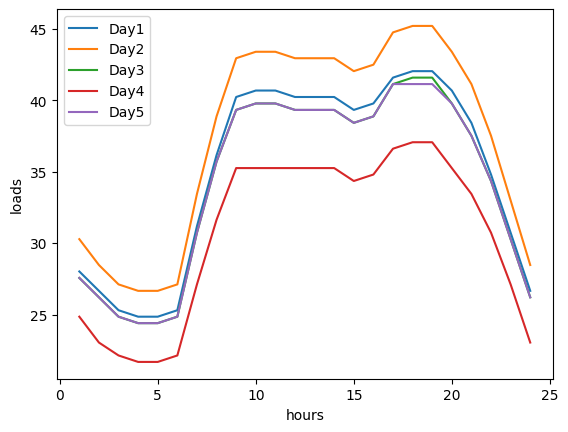

In [142]:
demands = plt.plot(range(1,25),Pd_sum.T)
plt.xlabel("hours")
plt.ylabel("loads")
plt.legend(iter(demands), ("Day"+str(i) for i in range(1,6)))

In [143]:
print(M.shape)
print(Pl.shape)
print(rhr.T[0])

(118, 186)
(186, 1)
[ 180  240  180  180  180   60    0  420   60  420  180  180  180  420
  180  180  180  180  180 3000 3000 3000 3000 3000 3000 3000 3000 3000
 3000   60  120    0  180  180    0  120  120  120  120  120  180   60
   60   60   60  180  180  180  420  240  180   60  180  420]


In [144]:
d1 = Pd[0].T

T = 24

p = cp.Variable((generator_df.shape[0],T))
r = cp.Variable((generator_df.shape[0],T))
theta = cp.Variable((N,T))
u = cp.Variable((generator_df.shape[0],T),boolean = True) # Commitment variable
v = cp.Variable((generator_df.shape[0],T),boolean = True) # Startup variable
w = cp.Variable((generator_df.shape[0],T),boolean = True) # Shutdown variable

obj = cp.Minimize(cp.sum(cl.T@p + csu.T@v + csd.T@w + cnl.T@u + cr.T@r))
# obj = cp.Minimize(cp.sum(linear_cost.T@p))

power_flow_constraints = [Eg@p - d1 == B@theta]
flow_limits = [-Pl@np.ones((1,T)) <= np.diag(b)@M.T@theta, np.diag(b)@M.T@theta <= Pl@np.ones((1,T))]
generator_limits = [np.diag(pg_min.T[0])@u + r <= p, p <= np.diag(pg_max.T[0])@u - r]
ramp_limits_startup = [p[:,i] - p[:,i-1] <= np.diag(rhr.T[0])@u[:,i-1] + np.diag(rsu.T[0])@v[:,i] for i in range(1,T)]
ramp_limits_shutdown = [p[:,i-1] - p[:,i] <= np.diag(rhr.T[0])@u[:,i] + np.diag(rsd.T[0])@w[:,i] for i in range(1,T)]
commitment_constraints = [v[:,i] - w[:,i] == u[:,i] - u[:,i-1] for i in range(1,T)]

min_up_time_constraints = []
for idx, utime in enumerate(Ti_on):
    for t in range(utime[0]-1,T):
        min_up_time_constraints += [cp.sum(v[idx,t-utime[0]+1:t+1]) <= u[idx,t]]

min_down_time_constraints = []
for idx, dtime in enumerate(Ti_off):
    for t in range(dtime[0]-1,T):
        min_down_time_constraints += [cp.sum(w[idx,t-dtime[0]+1:t+1]) <= 1-u[idx,t]]

reserve_constraints = []#[cp.sum(r[:,t]) >= 0.07*cp.sum(d1[:,t]) for t in range(T)]
reserve_constraints += [cp.sum(r[:,t]) >= p[idx,t] + r[idx,t] for t in range(T) for idx,_ in enumerate(pg_max)]
reserve_constraints += [r <= np.diag(pg_max.T[0])@u, r >= 0]
for t in range(1, T):
    reserve_constraints += [v[:,t]-w[:,t] == u[:,t] - u[:,t-1]]

# constraints = power_flow_constraints + flow_limits + generator_limits + commitment_constraints + min_up_time_constraints + min_down_time_constraints + reserve_constraints + ramp_limits_startup + ramp_limits_shutdown
constraints = power_flow_constraints + flow_limits + generator_limits + commitment_constraints + reserve_constraints + ramp_limits_startup + ramp_limits_shutdown + min_up_time_constraints + min_down_time_constraints

prob = cp.Problem(obj, constraints)
prob.solve(reoptimize=True, verbose=True,MIPgap = 0.01)

                                     CVXPY                                     
                                     v1.2.2                                    
(CVXPY) May 09 06:28:41 PM: Your problem has 9312 variables, 3464 constraints, and 0 parameters.
(CVXPY) May 09 06:28:42 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) May 09 06:28:42 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) May 09 06:28:42 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) May 09 06:28:42 PM: Compiling problem (target solver=GUROBI).
(CVXPY) May 09 06:28:42 PM: Reduction chain: CvxAttr2Constr -> Qp2SymbolicQp -> QpMatrixS

191758.00920345797